# GHCNh

>The Global Historical Climatology Network hourly (GHCNh) is a next generation hourly/synoptic dataset that replaces the Integrated Surface Dataset (ISD). GHCNh consists of hourly and synoptic surface weather observations from fixed, land-based stations. This dataset is compiled from numerous data sources maintained by NOAA, the U.S. Air Force, and many other meteorological agencies (Met Services) around the world. These sources have been reformatted into a common data format and then harmonized into a set of unique period-of-record station files, which are then provided as GHCNh.

We download the raw files then format them.

[PDF documentation (https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf)](https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh_DOCUMENTATION.pdf).

In [1]:
import sys
import os
sys.path.append('../../')
from setup import CWD, SCRATCH_DIR, DATA_DIR, FIG_DIR
print(CWD)
print(DATA_DIR)
print(FIG_DIR)
print(SCRATCH_DIR)

/home/valencig/GPLLJ/
/home/valencig/GPLLJ/data/
/home/valencig/GPLLJ/figures/
/scratch/valencig/GPLLJ-Scratch/


In [2]:
os.system(f'wget -nc -P {DATA_DIR} https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/doc/ghcnh-station-list.csv')

File ‘/home/valencig/GPLLJ/data/ghcnh-station-list.csv’ already there; not retrieving.



0

## Parse station list

> ID, 1-11, Character
> 
> LATITUDE,13-20, Real
> 
> LONGITUDE, 22-30, Real

In [3]:
import polars as pl

metadata = pl.read_csv(
    os.path.join(DATA_DIR, 'ghcnh-station-list.csv'),
    has_header=False,
    infer_schema_length=False, # read as string
    truncate_ragged_lines=True,
    )\
    .rename({
        'column_1': 'id',
        'column_2': 'lat',
        'column_3': 'lon',
    })\
    .with_columns(
        pl.col('lat').str.strip_chars().cast(pl.Float32),
        pl.col('lon').str.strip_chars().cast(pl.Float32),
    )
# Only get CNA stations
cna_metadata = metadata.filter(
    (pl.col('lon') <= -90) &
    (pl.col('lon') >= -105) &
    (pl.col('lat') <= 50) &
    (pl.col('lat') >= 25)
).select(['id', 'lat', 'lon'])
cna_metadata

id,lat,lon
str,f32,f32
"""CAM00071843""",49.799999,-97.133301
"""CAM00071847""",49.833302,-92.75
"""CAN04012400""",49.220001,-102.970001
"""CAN04019041""",49.817001,-104.182999
"""CAN0401HP5R""",49.700001,-103.800003
…,…,…
"""USW00094995""",40.848301,-96.565002
"""USW00094996""",40.695301,-96.854202
"""USW00094997""",46.446701,-95.2117


## Sanity check 

Make sure all potential stations are in the right area

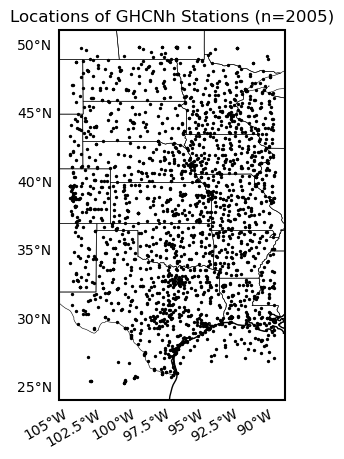

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_latlon(ax):
    gl = ax.gridlines(
        crs=ccrs.PlateCarree(), draw_labels=True, which='both',
        linewidth=1, color='k', alpha=1, linestyle='--'
    )
    gl.right_labels = None
    gl.top_labels = None
    gl.xlines = None
    gl.ylines = None
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    # Increase the ticksize
    gl.xlabel_style = {'size': 10, 'color': 'k', 'rotation':30, 'ha':'right'}
    gl.ylabel_style = {'size': 10, 'color': 'k', 'weight': 'normal'}

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: locations of all the sites
pts = ax.scatter(cna_metadata['lon'], cna_metadata['lat'], transform=ccrs.PlateCarree(), c='k', s=2)
ax.add_feature(cfeature.STATES, linewidth=0.4)
ax.add_feature(cfeature.COASTLINE, linewidth=1)
add_latlon(ax)
ax.set_title(f'Locations of GHCNh Stations (n={len(cna_metadata)})')
for spine in ax.spines.values():
    spine.set_linewidth(1.5)
plt.show()

## Set up directories and save files

In [5]:
from IPython.display import clear_output
GHCNh_dir = os.path.join(SCRATCH_DIR, 'GHCNh/')
if not os.path.exists(GHCNh_dir):
    os.mkdir(GHCNh_dir)

from tqdm import tqdm
import numpy as np
# Now download files
ids = cna_metadata['id'].to_numpy()
wget_file = os.path.join(DATA_DIR, 'ghcnh_station_download_links.txt')
requests = [
    f'https://www.ncei.noaa.gov/oa/global-historical-climatology-network/hourly/access/by-station/GHCNh_{station}_por.psv\n' \
    for station in ids
]
with open(wget_file, 'w') as f:
    f.writelines(requests)


# clear_output(wait=True) # Unique output for each file
# print(f'Downloading Station {i+1}/{len(ids)}')
print('I prefer to run this in a terminal rather than using os.system()')
print(f'wget -nc -P {GHCNh_dir} -i {wget_file}')

I prefer to run this in a terminal rather than using os.system()
wget -nc -P /scratch/valencig/GPLLJ-Scratch/GHCNh/ -i /home/valencig/GPLLJ/data/ghcnh_station_download_links.txt


In [6]:
os.system(f'du -sh {GHCNh_dir}')

399G	/scratch/valencig/GPLLJ-Scratch/GHCNh/


0

## Preprocess and save to one large dataframe

We will extract variables `wind_speed`,`wind_direction`, and `wind_gust`. Descriptions are as follows:

> wind_direction = Wind Direction from true north using compass directions (e.g. 360 = true north,
180 = south, 270 = west, etc.). Note: A direction of “000” is given for calm winds.(whole
degrees)

> wind_speed = Wind Speed (meters per second)

> wind_gust = Peak short duration (usually < 20 seconds) wind speed (meters per second) that
exceeds the wind_speed average

Each variable has some unique identifiers. From the documentation:

> variable (see section IV, Table 1)
>
> variable_Measurement_Code (see section V, Table 2)
>
> variable_Quality_Code (see section VI, Table 3)
>
> variable_Report_Type (see section VII, Table 4)
>
> variable_Source_Code (see section XI, Table 6)

The quality codes are documented in Dunn et al. (2016) ([https://gi.copernicus.org/preprints/gi-2016-9/gi-2016-9.pdf](https://gi.copernicus.org/preprints/gi-2016-9/gi-2016-9.pdf)). We currently ignore all quality and measurement codes.

Times are also corrected to Central Standard Time (CST, -6 UTC) in order to facilitate the study of diurnal variations.

In [7]:
schema_overrides = {
    'Year': pl.Int16,
    'Month': pl.Int16,
    'Day': pl.Int16,
    'Hour': pl.Int16,
    'Minute': pl.Int16,
    'wind_speed': pl.Float32,
    'wind_direction': pl.Float32,
    'Latitude': pl.Float32,
    'Longitude': pl.Float32,
}
cols_to_keep = [
    'Station_ID',
    'Station_name',
    'Latitude',
    'Longitude',
    'time',
    'wind_speed',
    'wind_direction',
]
df = pl.scan_csv(
    f'{GHCNh_dir}*.psv',
    separator='|', # pipe separated
    infer_schema_length=False, # read everything as a string
    schema_overrides=schema_overrides,
    ignore_errors=True, # some wind direction measurements are odd (e.g. "AA1")
    )
parsed = (
    df
    # There are one or two lines where wind_direction was improperly coded
    .filter(pl.col('wind_direction') >= 0)
    .filter(pl.col('wind_direction') <= 360)
    # Remove stations with no wind speed
    .filter(pl.col('wind_speed') >= 0)
    # Create a time column
    .with_columns(
        pl.datetime(
            pl.col('Year'), pl.col('Month'), pl.col('Day'), pl.col('Hour'), pl.col('Minute'),
        ).alias('time'))
    # Convert to CST
    .with_columns(time=pl.col('time').dt.offset_by('-6h'))
    .select(cols_to_keep)
)

GHCNh_file = os.path.join(SCRATCH_DIR, 'GHCNh_cna.parquet')
parsed.sink_parquet(GHCNh_file)

In [8]:
os.system(f'ls -lhs {SCRATCH_DIR}')

total 3.6G
   0 drwxr-xr-x 1 valencig valencig    0 May 29 17:13 GHCNh
1.8G -rw-r--r-- 1 valencig valencig 1.8G May 30 14:50 GHCNh_cna.parquet
1.8G -rw-r--r-- 1 valencig valencig 1.8G May 28 16:05 isd_lite_cna.csv


0